# Running on new images
This notebook will walk you step by step through the process of using a pre-trained model to detect traffic signs in an image.

# Imports

In [25]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import os
import tensorflow as tf

# tf.enable_eager_execution()

from matplotlib import pyplot as plt
# matplotlib.use('TkAgg')  # Use TkAgg to show images

# from PIL import Image
import glob as glob
import random
import pickle

import sys
import cv2

%matplotlib inline
# tf.executing_eagerly()

# Environment setup

In [26]:


sys.path.append('../models/research')  # Replace with the path to TensorFlow Object Detection API
sys.path.append('../darkflow')  # Replace with the path to Darkflow

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util


# Tensorflow Object Detection API

## Model preparation 

In [27]:
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
# MODEL_NAME = 'faster_rcnn_resnet_101'
# MODEL_NAME = 'faster_rcnn_resnet50'
MODEL_NAME = 'faster_rcnn_inception_v2'
# MODEL_NAME = 'rfcn_resnet101'
# MODEL_NAME = 'ssd_inception_v2'
# MODEL_NAME = 'ssd_mobilenet_v1'

In [28]:
# Path to frozen detection graph. This is the actual model that is used for the traffic sign detection.
MODEL_PATH = os.path.join('models', MODEL_NAME)
PATH_TO_CKPT = os.path.join(MODEL_PATH,'inference_graph/frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('gtsdb_data', 'gtsdb3_label_map.pbtxt')

NUM_CLASSES = 3


## Load a (frozen) Tensorflow model into memory

In [29]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `2`, we know that this corresponds to `mandatory`.

In [30]:
PATH_TO_LABELS = '/home/yuxing/my_project/traffic-sign-detection/gtsdb_data/gtsdb3_label_map.pbtxt'

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(label_map)


item {
  name: "prohibitory"
  id: 1
}
item {
  name: "mandatory"
  id: 2
}
item {
  name: "danger"
  id: 3
}



## Helper code

In [31]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    #return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
    return np.array(image.getdata()).reshape((im_height, im_width, 3))

## Detection

In [32]:

PATH_TO_TEST_IMAGES_DIR = '/home/yuxing/my_project/traffic-sign-detection/test_images'

TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))

# Size, in inches, of the output images.
IMAGE_SIZE = (20, 20)

In [33]:

# Function to print detections
def print_detections(sess, image_np_expanded, detection_graph, confidence_threshold=0.5):
    # Get the tensors for detection
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

    # Run the session to get the detection boxes, scores, and classes
    (boxes, scores, classes) = sess.run(
        [detection_boxes, detection_scores, detection_classes],
        feed_dict={image_tensor: image_np_expanded}
    )

    # Filter out the results with confidence scores less than the threshold
    filter_indices = np.where(scores[0] >= confidence_threshold)[0]

    # Apply the filter to boxes, scores and classes
    filtered_boxes = boxes[0][filter_indices]
    filtered_scores = scores[0][filter_indices]
    filtered_classes = classes[0][filter_indices]

    print("Filtered Detection Boxes:", filtered_boxes)
    print("Filtered Detection Scores:", filtered_scores)
    print("Filtered Detection Classes:", filtered_classes)


Filtered Detection Boxes: [[0.35613373 0.45915684 0.42445537 0.51562685]]
Filtered Detection Scores: [0.9997478]
Filtered Detection Classes: [3.]


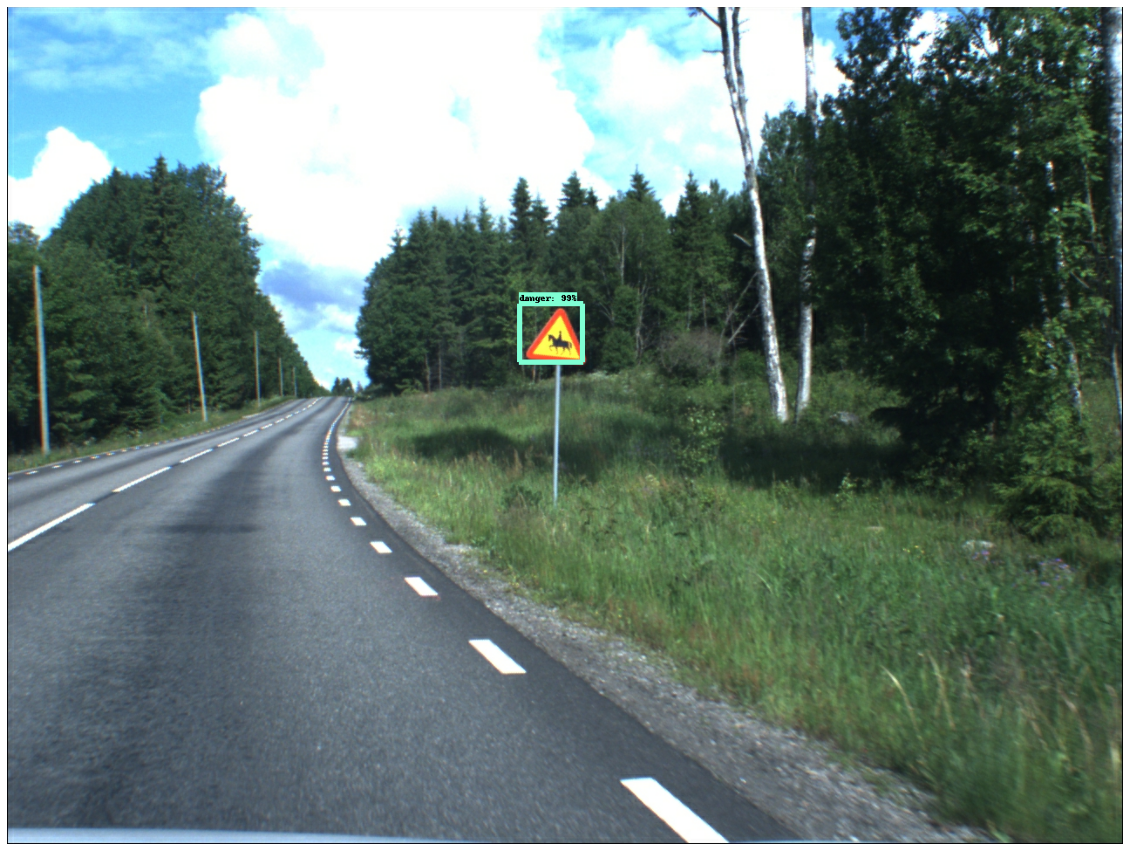

In [34]:

saved_detection_results = {}

# Run inference and visualization
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for idx, image_path in enumerate(TEST_IMAGE_PATHS):
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image_data = tf.read_file(image_path)
            image_decoded = tf.image.decode_image(image_data)
            image_np = sess.run(image_decoded)
            image_np_expanded = np.expand_dims(image_np, axis=0)

            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})

            saved_detection_results[image_path] = {
                'boxes': boxes,
                'scores': scores,
                'classes': classes,
                'num_detections': num_detections
            }

            # Print and visualize detection results on adversarial image
            print_detections(sess, image_np_expanded, detection_graph)
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            plt.figure(idx, figsize=IMAGE_SIZE)
            plt.axis('off')
            plt.imshow(image_np)


Iteration 1
Computing gradient approximation for downsampled image
approx_logits 4.110912394897449
original_loss 4.110912394897449
approx_logits 4.099322111977066
perturbed_loss 4.099322111977066
Gradient at idx (0, 49, 75, 0) : -0.0023180565
approx_logits 4.111036357256201
perturbed_loss 4.111036357256201
Gradient at idx (0, 11, 52, 0) : 2.479247e-05
approx_logits 4.110912394897449
perturbed_loss 4.110912394897449
Gradient at idx (0, 49, 105, 2) : 0.0
approx_logits 4.095669963715661
perturbed_loss 4.095669963715661
Gradient at idx (0, 36, 84, 1) : -0.0030484863
approx_logits 4.1108823456559325
perturbed_loss 4.1108823456559325
Gradient at idx (0, 41, 34, 2) : -6.009848e-06
approx_logits 4.110912394897449
perturbed_loss 4.110912394897449
Gradient at idx (0, 12, 89, 2) : 0.0
approx_logits 4.107911787737686
perturbed_loss 4.107911787737686
Gradient at idx (0, 43, 39, 1) : -0.00060012145
approx_logits 4.110912394897449
perturbed_loss 4.110912394897449
Gradient at idx (0, 11, 89, 2) : 0.0


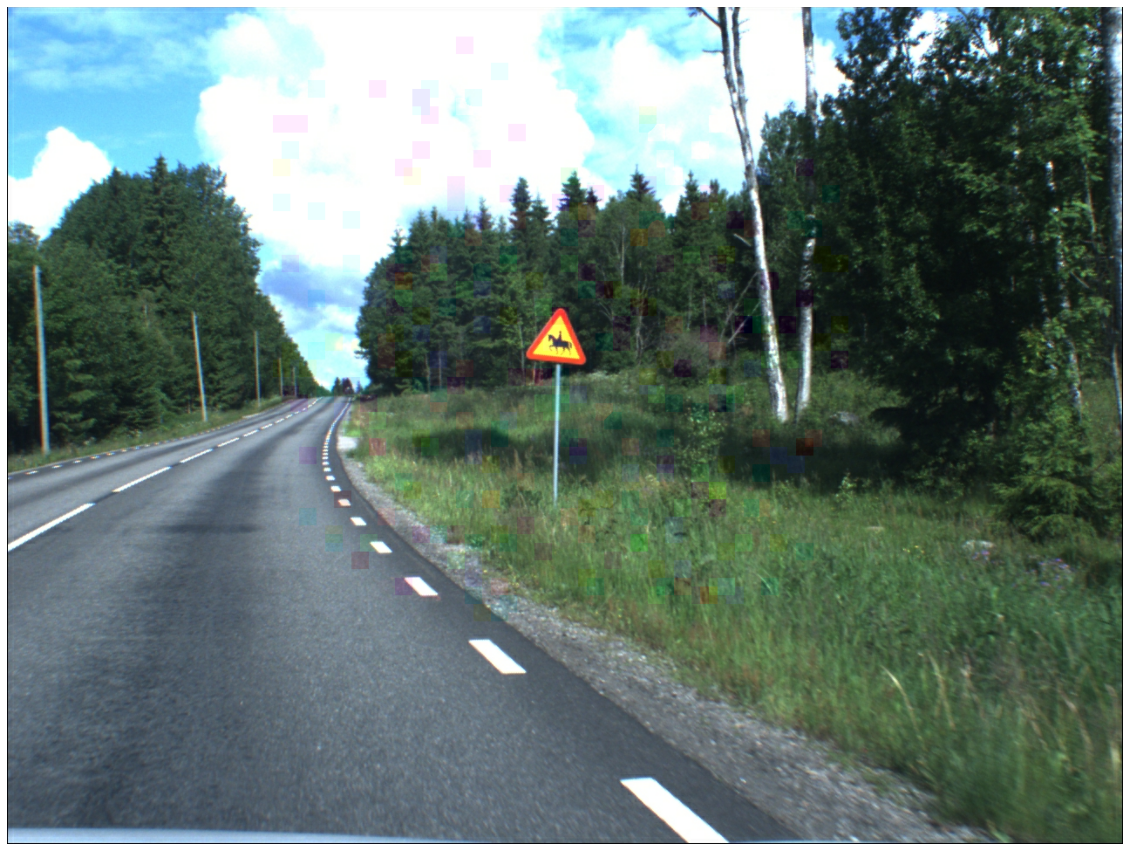

Filtered Detection Boxes: [[0.3569079  0.4594986  0.42319822 0.5172467 ]]
Filtered Detection Scores: [0.999668]
Filtered Detection Classes: [3.]


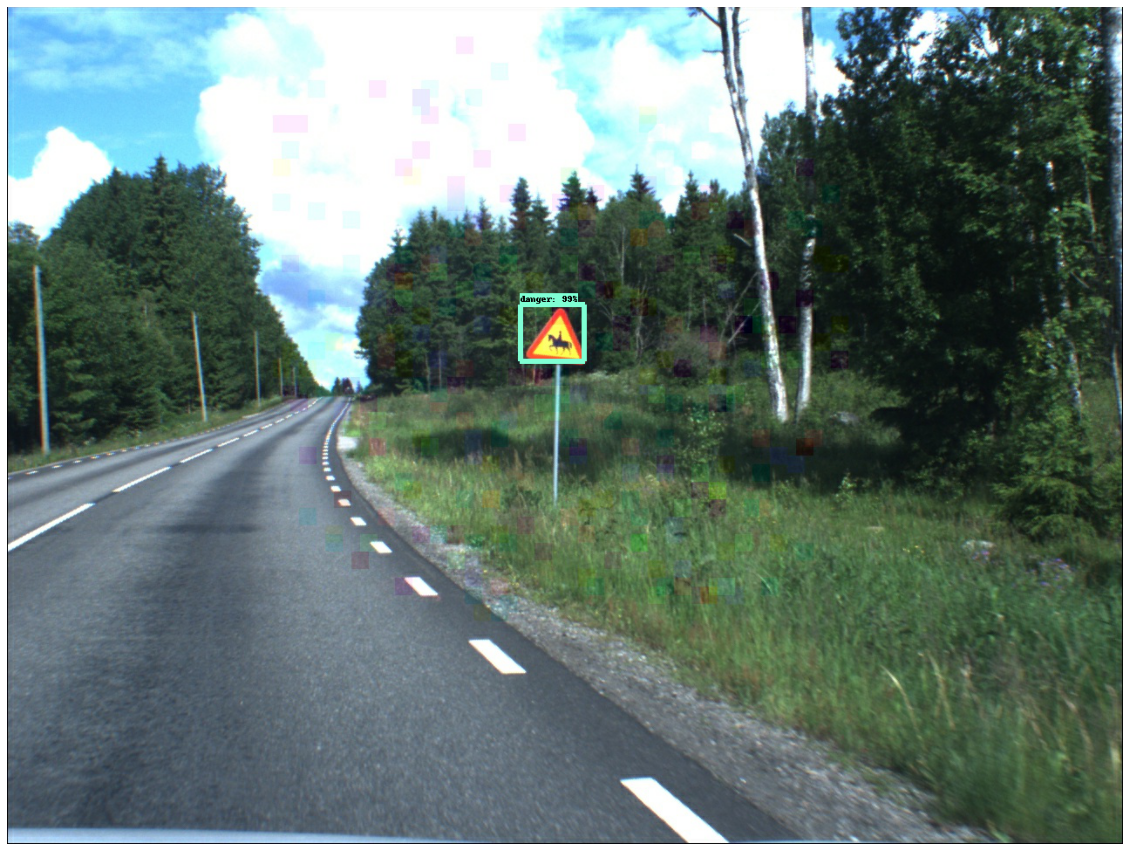

In [39]:
# Create save directory for images
SAVE_DIR = 'saved_images'
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

def print_shape_dtype(arr, name):
    print(f"{name}: Shape = {arr.shape}, dtype = {arr.dtype}")

# Function to downsample an image
def downsample(image, factor=0.1):
    return cv2.resize(image, None, fx=factor, fy=factor, interpolation=cv2.INTER_LINEAR)

# Function to upsample an image
def upsample(image, original_shape):
    return cv2.resize(image, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_LINEAR)

def compute_loss(sess, image_np_expanded, detection_graph):
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    
    (scores, classes) = sess.run([scores, classes], feed_dict={image_tensor: image_np_expanded})
    max_score_index = np.argmax(scores)
    score = scores[0][max_score_index]
    approx_logits = np.log(score / (1 - score))
    print('approx_logits',approx_logits)
    return approx_logits

def approximate_gradient(sess, image_np_expanded, detection_graph, h=5, num_samples=1000):
    original_loss = compute_loss(sess, image_np_expanded, detection_graph)
    print('original_loss',original_loss)
    grad_approx = np.zeros_like(image_np_expanded).astype(np.float32)
    
    indices = np.random.choice(np.prod(image_np_expanded.shape), num_samples, replace=False)
    
    for flat_idx in indices:
        idx = np.unravel_index(flat_idx, image_np_expanded.shape)
        perturb = np.zeros_like(image_np_expanded)
        perturb[idx] = h
        perturbed_image = image_np_expanded + perturb
        perturbed_loss = compute_loss(sess, perturbed_image, detection_graph)
        print('perturbed_loss',perturbed_loss)
        grad_approx[idx] = (perturbed_loss - original_loss) / h
        print("Gradient at idx", idx, ":", grad_approx[idx])


    print("Perturbed Loss:", perturbed_loss)
    print("Original Loss:", original_loss)
    print('grad_approx',grad_approx)
    
    return grad_approx


# Main execution
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Define tensors for detection
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        scores = detection_graph.get_tensor_by_name('detection_scores:0')
        classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        for idx, image_path in enumerate(TEST_IMAGE_PATHS):
            image_data = tf.read_file(image_path)
            image_decoded = tf.image.decode_image(image_data)
            image_np = sess.run(image_decoded)
            original_shape = image_np.shape


            # Initialize adversarial image
            adv_image = image_np.copy()

            # Number of iterations to perform
            num_iterations = 1

            # Iterative loop to find the best adversarial image
            for i in range(num_iterations):
                print(f"Iteration {i+1}")

                # Downsample the current adversarial image for approximating gradient
                adv_image_low_res = downsample(adv_image)
                adv_image_low_res_expanded = np.expand_dims(adv_image_low_res, axis=0)

                # Compute the approximate gradient on low-res image
                print("Computing gradient approximation for downsampled image")
                grad_approx_low_res = approximate_gradient(sess, adv_image_low_res_expanded, detection_graph)

                # Upsample gradient to original resolution
                print("Upsampling gradient approximation")
                grad_approx = upsample(grad_approx_low_res[0], original_shape)

                # Update adversarial image
                eps = 20  # Perturbation factor, adjust as needed
                adv_image = adv_image + eps * np.sign(grad_approx)
                adv_image = np.clip(adv_image, 0, 255).astype(np.uint8)

            # Display the adversarial image
            plt.figure(idx, figsize=IMAGE_SIZE)
            plt.axis('off')
            plt.imshow(adv_image)
            plt.show()

            # Save adversarial image
            save_path = os.path.join(SAVE_DIR, f'adv_image_{idx}.jpg')
            cv2.imwrite(save_path, cv2.cvtColor(adv_image, cv2.COLOR_RGB2BGR))

            # Reload the saved adversarial image
            adv_image_data = cv2.imread(save_path)
            adv_image_rgb = cv2.cvtColor(adv_image_data, cv2.COLOR_BGR2RGB)
            adv_image_expanded = np.expand_dims(adv_image_rgb, axis=0)

            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: adv_image_expanded}
            )

            # Print and visualize detection results on adversarial image
            print_detections(sess, adv_image_expanded, detection_graph)
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                adv_image_rgb,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6,
                min_score_thresh=0.5
            )
            
            plt.figure(idx, figsize=IMAGE_SIZE)
            plt.axis('off')
            plt.imshow(adv_image_rgb)
            plt.show()
